<a href="https://colab.research.google.com/github/pachterlab/kallistobustools/blob/master/notebooks/kb_slingshot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
install.packages(c("BiocManager", "scales", "viridis"))
BiocManager::install(c("multtest", "slingshot", "BUSpaRse", "SingleR", "DropletUtils"))
install.packages("Seurat")

Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘numDeriv’, ‘SQUAREM’, ‘miniUI’, ‘zoo’, ‘packrat’, ‘igraph’, ‘lava’, ‘listenv’, ‘ggridges’, ‘minqa’, ‘nloptr’, ‘checkmate’, ‘matrixStats’, ‘inline’, ‘colourpicker’, ‘dygraphs’, ‘gtools’, ‘rsconnect’, ‘shinyjs’, ‘shinythemes’, ‘threejs’, ‘xts’, ‘prodlim’, ‘future’, ‘SnowballC’, ‘ISOcodes’, ‘bayesplot’, ‘lme4’, ‘loo’, ‘rstan’, ‘rstantools’, ‘shinystan’, ‘StanHeaders’, ‘RcppEigen’, ‘DiceDesign’, ‘globals’, ‘gower’, ‘ipred’, ‘timeDate’, ‘furrr’, ‘hunspell’, ‘tokenizers’, ‘janeaustenr’, ‘stopwords’, ‘rstanarm’, ‘pROC’, ‘dials’, ‘infer’, ‘parsnip’, ‘recipes’, ‘rsample’, ‘tidytext’, ‘tidypredict’, ‘tidyposterior’, ‘yardstick’, ‘gridExtra’


Warning message in install.packages(c("BiocManager", "tidymodels", "scales", "viridis")):
“installation of package ‘rstanarm’ had non-zero exit status”
Warning message in install.packages(c("BiocManager", "tidymodels", "scales", "viridis")):

In [0]:
system("wget https://github.com/pachterlab/kallisto/releases/download/v0.46.1/kallisto_linux-v0.46.1.tar.gz")
untar("kallisto_linux-v0.46.1.tar.gz")
system("cp kallisto/kallisto /usr/local/bin")

In [0]:
BiocManager::install("SingleR")

Bioconductor version 3.10 (BiocManager 1.30.10), R 3.6.2 (2019-12-12)

Installing package(s) 'SingleR'

also installing the dependencies 'interactiveDisplayBase', 'RcppHNSW', 'AnnotationHub', 'DelayedMatrixStats', 'BiocNeighbors', 'ExperimentHub'




In [0]:
system("pip3 install kb-python")

In [0]:
library(slingshot)
library(BUSpaRse)
library(DropletUtils)
library(tidyverse)
library(Seurat)
library(scales)
library(viridis)
library(Matrix)
theme_set(theme_bw())

In [0]:
# Download data
if (!dir.exists("./data")) dir.create("./data")
if (!file.exists("./data/neuron_1k_v3_fastqs.tar")) {
  download.file("http://cf.10xgenomics.com/samples/cell-exp/3.0.0/neuron_1k_v3/neuron_1k_v3_fastqs.tar", 
      "./data/neuron_1k_v3_fastqs.tar", method = "wget", quiet = TRUE)
}

In [0]:
untar("./data/neuron_1k_v3_fastqs.tar", exdir = "./data")

In [0]:
# Mouse transcriptome
if (!dir.exists("./reference")) dir.create("./reference")
if (!file.exists("./reference/mm_cdna99.fa.gz")) {
  download.file("ftp://ftp.ensembl.org/pub/release-99/fasta/mus_musculus/cdna/Mus_musculus.GRCm38.cdna.all.fa.gz", 
  "./reference/mm_cdna99.fa.gz", method = "wget", quiet = TRUE)
}

In [0]:
system("kallisto index -i ./reference/mm_tr_index99.idx ./reference/mm_cdna99.fa.gz", intern = TRUE)

character(0)

In [0]:
tr2g <- tr2g_fasta("./reference/mm_cdna99.fa.gz")

Reading FASTA file.



In [0]:
save_tr2g_bustools(tr2g, file_save = "./reference/tr2g_mm99.tsv")

In [0]:
system("chmod -R 777 data/")

In [0]:
fn <- list.files("data/neuron_1k_v3_fastqs", full.names = TRUE)
fn <- fn[str_detect(fn, "R\\d_")]
fn

[1] "data/neuron_1k_v3_fastqs/neuron_1k_v3_S1_L001_R1_001.fastq.gz"
[2] "data/neuron_1k_v3_fastqs/neuron_1k_v3_S1_L001_R2_001.fastq.gz"
[3] "data/neuron_1k_v3_fastqs/neuron_1k_v3_S1_L002_R1_001.fastq.gz"
[4] "data/neuron_1k_v3_fastqs/neuron_1k_v3_S1_L002_R2_001.fastq.gz"

In [0]:
system(paste("kb count -i reference/mm_tr_index99.idx -g reference/tr2g_mm99.tsv -x 10xv3 -o output",
paste(fn, collapse = " ")), intern = TRUE)

character(0)

In [0]:
res_mat <- read_count_output("./output/counts_unfiltered", name = "cells_x_genes", tcc = FALSE)

In [0]:
dim(res_mat)

[1]  36711 399524

In [0]:
tot_counts <- Matrix::colSums(res_mat)
summary(tot_counts)

     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
     0.00      1.00      1.00     40.47      5.00 154216.00 

In [0]:
# Compute barcode rank
bc_rank <- barcodeRanks(res_mat, lower = 1000)

In [0]:
#' Knee plot for filtering empty droplets
#' 
#' Visualizes the inflection point to filter empty droplets. This function plots 
#' different datasets with a different color. Facets can be added after calling
#' this function with `facet_*` functions.
#' 
#' @param bc_rank A `DataFrame` output from `DropletUtil::barcodeRanks`.
#' @return A ggplot2 object.
knee_plot <- function(bc_rank) {
  knee_plt <- tibble(rank = bc_rank[["rank"]],
                     total = bc_rank[["total"]]) %>% 
    distinct() %>% 
    dplyr::filter(total > 0)
  annot <- tibble(inflection = metadata(bc_rank)[["inflection"]],
                  rank_cutoff = max(bc_rank$rank[bc_rank$total > metadata(bc_rank)[["inflection"]]]))
  p <- ggplot(knee_plt, aes(rank, total)) +
    geom_line() +
    geom_hline(aes(yintercept = inflection), data = annot, linetype = 2) +
    geom_vline(aes(xintercept = rank_cutoff), data = annot, linetype = 2) +
    scale_x_log10() +
    scale_y_log10() +
    annotation_logticks() +
    labs(x = "Rank", y = "Total UMIs")
  return(p)
}

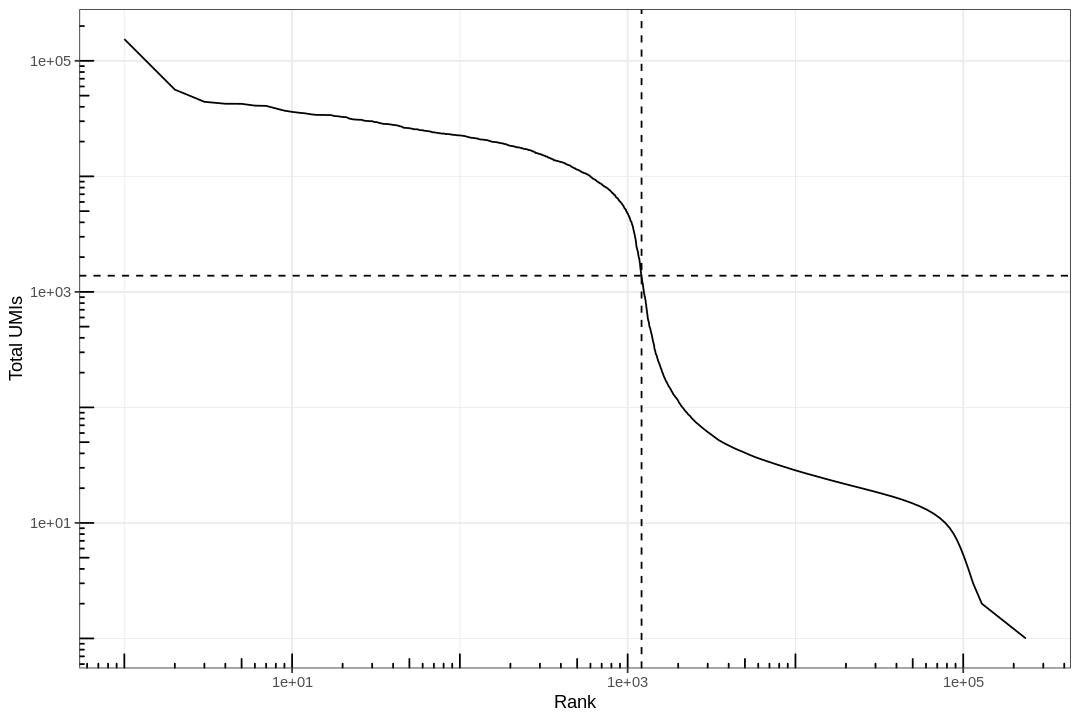

In [0]:
options(repr.plot.width=9, repr.plot.height=6)
knee_plot(bc_rank)

In [0]:
# Filter the matrix
res_mat <- res_mat[, tot_counts > metadata(bc_rank)$inflection]
res_mat <- res_mat[Matrix::rowSums(res_mat) > 0,]
dim(res_mat)

[1] 20198  1210

In [0]:
rownames(res_mat) <- str_remove(rownames(res_mat), "\\.\\d+")

In [0]:
mouse.rnaseq <- MouseRNAseqData(ensembl = TRUE)
sce <- SingleCellExperiment(assays = list(counts = res_mat))
sce <- logNormCounts(sce)

ERROR: ignored

In [0]:
annots <- SingleR(sce, ref = mouse.rnaseq, labels = colData(mouse.rnaseq)$label.fine,
de.method = "wilcox", method = "single", BPPARAM = MulticoreParam(4))

In [0]:
annots

In [0]:
seu <- CreateSeuratObject(mat_filtered) %>% 
  SCTransform() # normalize and scale
# Add cell type annotation to metadata
seu <- AddMetaData(seu, setNames(annot$labels[ind], cells_use), 
                   col.name = "cell_type")

In [0]:
VlnPlot(seu, c("nCount_RNA", "nFeature_RNA"), pt.size = 0.1, ncol = 1, group.by = "cell_type")

In [0]:
ggplot(seu@meta.data, aes(nCount_RNA, nFeature_RNA, color = cell_type)) +
  geom_point(size = 0.5) +
  scale_color_brewer(type = "qual", palette = "Set2", name = "cell type") +
  scale_x_log10() +
  scale_y_log10() +
  theme_bw() +
  # Make points larger in legend
  guides(color = guide_legend(override.aes = list(size = 3))) +
  labs(x = "Total UMI counts", y = "Number of genes detected")

## Dimension reduction

In [0]:
seu <- RunPCA(seu, npcs = 70, verbose = FALSE)
ElbowPlot(seu, ndims = 70)

The y axis is standard deviation (not variance), or the singular values from singular value decomposition on the data performed for PCA.

In [0]:
DimPlot(seu, reduction = "pca",
        group.by = "cell_type", pt.size = 0.5, label = TRUE, repel = TRUE) +
  scale_color_brewer(type = "qual", palette = "Set2")

In [0]:
seu <- RunTSNE(seu, dims = 1:50, verbose = FALSE)
DimPlot(seu, reduction = "tsne",
        group.by = "cell_type", pt.size = 0.5, label = TRUE, repel = TRUE) +
  scale_color_brewer(type = "qual", palette = "Set2")

UMAP can better preserve pairwise distance of cells than tSNE and can better separate cell populations than the first 2 PCs of PCA ([Becht et al. 2018](https://doi.org/10.1038/nbt.4314)), so the TI will be done on UMAP rather than tSNE or PCA. The current CRAN version of Seurat uses the R package `uwot` rather than the Python version for UMAP.

In [0]:
seu <- RunUMAP(seu, dims = 1:50, seed.use = 4867)
DimPlot(seu, reduction = "umap",
        group.by = "cell_type", pt.size = 0.5, label = TRUE, repel = TRUE) +
  scale_color_brewer(type = "qual", palette = "Set2")

Cell type annotation with `SingleR` requires a reference with bulk RNA seq data for isolated known cell types. The reference used for cell type annotation here does not differentiate between different types of neural progenitor cells; clustering can further partition the neural progenitor cells. Furthermore, `slingshot` is based on cluster-wise minimum spanning tree, so finding a good clustering is important to good trajectory inference with `slingshot`. The clustering algorithm used here is [Leiden](https://www.nature.com/articles/s41598-019-41695-z), which is an improvement over the commonly used Louvain; Leiden communities are guaranteed to be well-connected, while Louvain can lead to poorly connected communities.

In [0]:
names(seu@meta.data)

In [0]:
seu <- FindNeighbors(seu, verbose = FALSE, dims = 1:50)
seu <- FindClusters(seu, algorithm = 4, random.seed = 256, resolution = 1)
DimPlot(seu, pt.size = 0.5, reduction = "umap", group.by = "seurat_clusters", label = TRUE)

# Slingshot
## Trajectory inference
While the `slingshot` vignette uses `SingleCellExperiment`, `slingshot` can also take a matrix of cell embeddings in reduced dimension as input. We can optionally specify the cluster to start or end the trajectory based on biological knowledge. Here, since quiescent neural stem cells are in cluster 4, the starting cluster would be 4 near the top left of the previous plot.

Here, UMAP projections are used for trajectory inference, as in Monocle 3, for the purpose of visualization. However, **I no longer consider this a good idea**, due to distortions introduced by UMAP. See [this paper](https://www.biorxiv.org/content/10.1101/689851v3) for the extent non-linear dimension reduction methods distort the data. The latent dimension of the data is most likely far more than 2 or 3 dimensions, so forcing it down to 2 or 3 dimensions are bound to introduce distortions, just like how projecting the spherical surface of the Earth to 2 dimensions in maps introduces distortions. Furthermore, after the projection, some trajectories are no longer topologically feasible. For instance, imagine a stream coming out of the hole of a doughnut in 3D. This is not possible in 2D, so when that structure is projected to 2D, part of the stream may become buried in the middle of the doughnut, or the doughnut may be broken to allow the stream through, or part of the steam will be intermixed with part of the doughnut though they shouldn't. I recommend using a larger number of principal components instead, but in that case, the lineages and principal curves can't be visualized (we can plot the curves within a 2 dimensional subspace, such as the first 2 PCs, but that usually looks like abstract art and isn't informative about the lineages).

In [0]:
sds <- slingshot(Embeddings(seu, "umap"), clusterLabels = seu$seurat_clusters, 
                 start.clus = 4, stretch = 0)

Unfortunately, `slingshot` does not natively support `ggplot2`. So this is a function that assigns colors to each cell in base R graphics.

In [0]:
#' Assign a color to each cell based on some value
#' 
#' @param cell_vars Vector indicating the value of a variable associated with cells.
#' @param pal_fun Palette function that returns a vector of hex colors, whose
#' argument is the length of such a vector.
#' @param ... Extra arguments for pal_fun.
#' @return A vector of hex colors with one entry for each cell.
cell_pal <- function(cell_vars, pal_fun,...) {
  if (is.numeric(cell_vars)) {
    pal <- pal_fun(100, ...)
    return(pal[cut(cell_vars, breaks = 100)])
  } else {
    categories <- sort(unique(cell_vars))
    pal <- setNames(pal_fun(length(categories), ...), categories)
    return(pal[cell_vars])
  }
}

We need color palettes for both cell types and Leiden clusters. These would be the same colors seen in the Seurat plots.

In [0]:
cell_colors <- cell_pal(seu$cell_type, brewer_pal("qual", "Set2"))
cell_colors_clust <- cell_pal(seu$seurat_clusters, hue_pal())

In [0]:
plot(reducedDim(sds), col = cell_colors, pch = 16, cex = 0.5)
lines(sds, lwd = 2, type = 'lineages', col = 'black')

Again, the qNSCs are the brown points near the top left, NPCs are green, and neurons are pink. It seems that multiple neural lineages formed. This is a much more complicated picture than the two branches of neurons projected on the first two PCs in the pseudotime figure in the [kallisto | bustools paper](https://www.biorxiv.org/content/10.1101/673285v1) (Supplementary Figure 6.5). It also seems that `slingshot` did not pick up the glial lineage (oligodendrocytes and astrocytes), as the vast majority of cells here are NPCs or neurons. 

See how this looks with Leiden clusters.

In [0]:
plot(reducedDim(sds), col = cell_colors_clust, pch = 16, cex = 0.5)
lines(sds, lwd = 2, type = 'lineages', col = 'black')

Here `slingshot` thinks that somewhere around cluster 6 is a point where multiple neural lineages diverge. Different clustering (e.g. different random initiations of Louvain or Leiden algorithms) can lead to somewhat different trajectories, the the main structure is not affected. With different runs of Leiden clustering (without fixed seed), the branching point is placed in the region around its current location, near the small UMAP offshoot there.

Principal curves are smoothed representations of each lineage; pseudotime values are computed by projecting the cells onto the principal curves. What do the principal curves look like?

In [0]:
plot(reducedDim(sds), col = cell_colors, pch = 16, cex = 0.5)
lines(sds, lwd = 2, col = 'black')

Which cells are in which lineage? Here we plot the pseudotime values for each lineage.

In [0]:
nc <- 3
pt <- slingPseudotime(sds)
nms <- colnames(pt)
nr <- ceiling(length(nms)/nc)
pal <- viridis(100, end = 0.95)
par(mfrow = c(nr, nc))
for (i in nms) {
  colors <- pal[cut(pt[,i], breaks = 100)]
  plot(reducedDim(sds), col = colors, pch = 16, cex = 0.5, main = i)
  lines(sds, lwd = 2, col = 'black', type = 'lineages')
}